<a href="https://colab.research.google.com/github/SonamKul9527/Melanoma_Detection_Assignment/blob/main/sonam_k_nn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Problem Statement

Build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

We will build a multiclass classification model using a custom convolutional neural network in TensorFlow

In [3]:
## Mount Google Drive to load the data from Google Drive

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
## Unzipping the data from specified drive folder

!unzip -q "/content/gdrive/My Drive/CNN_assignment.zip" -d "/content/gdrive/My Drive/CNN_assignment"

In [4]:
!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
## Importing Required Libraries

import os
import PIL
import pathlib 
import Augmentor

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.optimizers import Adam
from keras.utils import load_img
from keras.callbacks import ModelCheckpoint,EarlyStopping
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np, pandas as pd

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [6]:
## Defining the path for Train and Test images directories

data_dir_train = pathlib.Path("/content/gdrive/My Drive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/")
data_dir_test = pathlib.Path("/content/gdrive/My Drive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test/")

In [7]:
## Count the number of images in Train and Test Directories. Using the glob to retrieve files/pathnames matching a specified pattern.

## Train Image Count
img_train_cnt = len(list(data_dir_train.glob('*/*.jpg')))
print(img_train_cnt)

## Test Image Count
img_test_cnt = len(list(data_dir_test.glob('*/*.jpg')))
print(img_test_cnt)

2239
118


### Data Visualization

Code to visualize one instance of all the nine classes present in the dataset

In [8]:
#image_dataset_from_directory() will return a tf.data.Dataset that yields batches of images from the subdirectories.
#label_mode is categorial, the labels are a float32 tensor of shape (batch_size, num_classes), representing a one-hot encoding of the class index.

image_dataset = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,batch_size=32,image_size=(180,180),
                                                                    label_mode='categorical',seed=123)

#all the classes of Skin Cancer
class_names = image_dataset.class_names

Found 2239 files belonging to 9 classes.


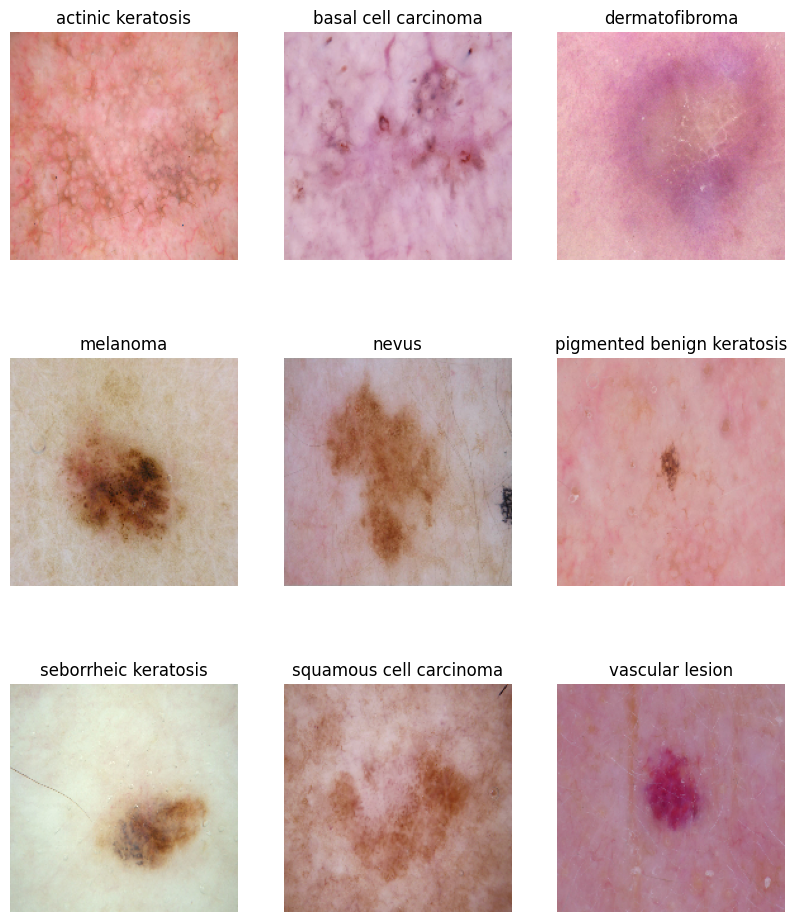

In [9]:
#Dictionary to store the path of image as per the class
files_path_dict = {}

for c in class_names:
    files_path_dict[c] = list(map(lambda x:str(data_dir_train)+'/'+c+'/'+x,os.listdir(str(data_dir_train)+'/'+c)))

plt.figure(figsize=(10,12))
index = 0
for c in class_names:
    path_list = files_path_dict[c][:1]
    index += 1
    plt.subplot(3,3,index)
    plt.imshow(load_img(path_list[0],target_size=(180,180)))
    plt.title(c)
    plt.axis("off")

The image_batch is a tensor of the shape (32, 180, 180, 3). This is a batch of 32 images of shape 180x180x3 (the last dimension refers to color channels RGB). The label_batch is a tensor of the shape (32,), these are corresponding labels to the 32 images.

Dataset.cache() keeps the images in memory after they're loaded off disk during the first epoch.

Dataset.prefetch() overlaps data preprocessing and model execution while training.

#### Counting the number of classes in each directory to check and evaluate Class Embalance

In [10]:
def each_cls_count(data_dir): 

  ## Counting the number of image in each class directory
  count = []
  for path in pathlib.Path(data_dir).iterdir() :
    if path.is_dir() :
       count.append(len([img_in_dir for img_in_dir in os.listdir(path)
                               if os.path.isfile(os.path.join(path, img_in_dir))]))
  ## Name of the classes
  sub_directory = [img_in_dir for img_in_dir in os.listdir(data_dir)
                    if os.path.isdir(os.path.join(data_dir, img_in_dir))]    

  ## Return the dataframe with image count and class.
  return pd.DataFrame(list(zip(sub_directory,count)), columns =['Class', 'No. of Image'])

In [11]:
class_data = each_cls_count(data_dir_train)
class_data

,Class,No. of Image
0,actinic keratosis,114
1,basal cell carcinoma,376
2,dermatofibroma,95
3,melanoma,438
4,nevus,357
5,pigmented benign keratosis,462
6,seborrheic keratosis,77
7,squamous cell carcinoma,181
8,vascular lesion,139


<Figure size 1200x1500 with 0 Axes>

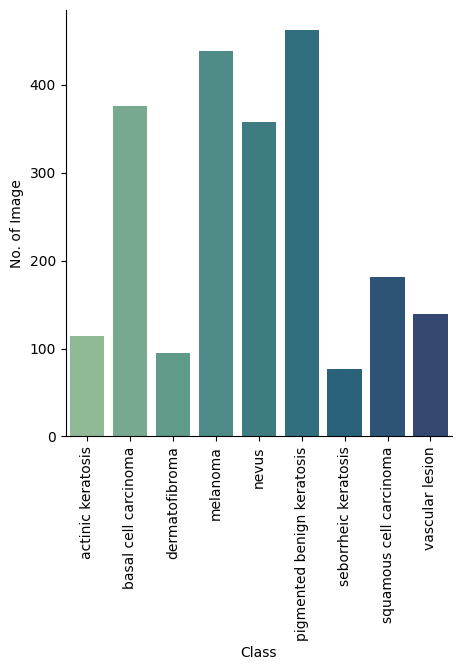

In [12]:
plt.figure(figsize=(12, 15))
sns.catplot(x="Class", y= "No. of Image", data = class_data, kind="bar", palette="crest")
plt.xticks(rotation = 90)
plt.show()

### Class distribution: 


*   Least Number of Samples : Seborrheic keratosis class has the least number
*   Highest Number of Samples : Pigmented benign keratosis class is the dominating class as per the training data	



From the above plot, we can clearly observe Class Imbalance in the training data. We need to handle it using the Augmentor Library

## Model Building

### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [13]:
batch_size = 32
img_height = 180
img_width = 180
input_size = (img_width, img_height, 3)

In [14]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
# Image_dataset_from_directory() will return a tf.data.Dataset that yields batches of images from the subdirectories.

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train, batch_size = batch_size, seed = 123, image_size = (img_height, img_width),
    validation_split=0.2, subset='training',  label_mode='categorical'
    )

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [15]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train, batch_size = batch_size, seed = 123, image_size = (img_height, img_width),
    validation_split=0.2, subset='validation', label_mode='categorical'
)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [16]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.

class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


Dataset.cache() keeps the images in memory after they're loaded off disk during the first epoch.

Dataset.prefetch() overlaps data preprocessing and model execution while training.

In [17]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Model Creation : 

* Creating a CNN model, which can accurately detect 9 classes present in the dataset. 
* We will be building the model, rescaling the images to normalize pixel values between (0,1).

In [18]:
num_of_classes = len(class_names)
print(num_of_classes)

9


In [30]:
model = Sequential()

## Rescaling the data
model.add(layers.experimental.preprocessing.Rescaling(1./255,input_shape= input_size))

## First Convulation Layer
model.add(Conv2D(32, kernel_size=(5, 5), activation='relu'))
model.add(Conv2D(64, kernel_size=(5,5), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))

## Second Convulation Layer
model.add(Conv2D(64, kernel_size=(5, 5), activation='relu'))
model.add(Conv2D(32, kernel_size=(5,5), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))

## Third Convolution 
model.add(Conv2D(32, kernel_size=(5,5), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))

# Flatten and put a fully connected Dense layer
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(num_of_classes, activation='softmax'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_10 (Conv2D)          (None, 176, 176, 32)      2432      
                                                                 
 conv2d_11 (Conv2D)          (None, 172, 172, 64)      51264     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 86, 86, 64)       0         
 2D)                                                             
                                                                 
 conv2d_12 (Conv2D)          (None, 82, 82, 64)        102464    
                                                                 
 conv2d_13 (Conv2D)          (None, 78, 78, 32)        51232     
                                                      

### Compile the model

Choose an appropirate optimiser and loss function for model training

In [31]:
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics=["accuracy"])

### Train the model

In [32]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 11s 142ms/step - loss: 2.0570 - accuracy: 0.1847 - val_loss: 2.0153 - val_accuracy: 0.2327
Epoch 2/20
56/56 [==============================] - 8s 136ms/step - loss: 1.9118 - accuracy: 0.2963 - val_loss: 1.8544 - val_accuracy: 0.2774
Epoch 3/20
56/56 [==============================] - 8s 134ms/step - loss: 1.6962 - accuracy: 0.3750 - val_loss: 1.7587 - val_accuracy: 0.3468
Epoch 4/20
56/56 [==============================] - 8s 134ms/step - loss: 1.6331 - accuracy: 0.4018 - val_loss: 1.6024 - val_accuracy: 0.4251
Epoch 5/20
56/56 [==============================] - 8s 134ms/step - loss: 1.6326 - accuracy: 0.4012 - val_loss: 1.5271 - val_accuracy: 0.4676
Epoch 6/20
56/56 [==============================] - 7s 134ms/step - loss: 1.5516 - accuracy: 0.4593 - val_loss: 1.5101 - val_accuracy: 0.4564
Epoch 7/20
56/56 [==============================] - 8s 134ms/step - loss: 1.5307 - accuracy: 0.4381 - val_loss: 1.5096 - val_accuracy: 0.4631
Epoch

### Visualizing training results

In [25]:
## User defined method to plot the Accuracy and Validation Plots

def plot_accuracyAndLoss(history, epochs) :
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs_range = range(epochs)

  plt.figure(figsize=(10, 7))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.grid(color = 'teal', linestyle = '--', linewidth = 0.5)
  plt.title('Training and Validation Accuracy')

  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.grid(color = 'teal', linestyle = '--', linewidth = 0.5)
  plt.show()

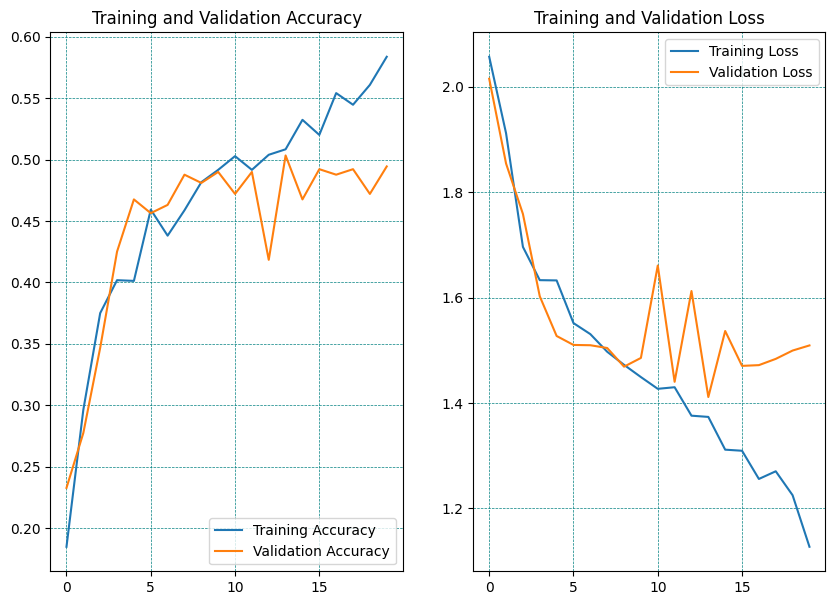

In [33]:
plot_accuracyAndLoss(history, epochs)

### Model Findings 

*   Model Overfitting : We can clearly observe from the above plot, the model seems to overfit as there patterns are almost similar to the train dataset.
*   Model has learned the patterns which is depicted from the above plots. This we can handle by adding more layers or tune the parameters or Data Augmentation.
*   Accuracy is around 58% whereas the validation accuracy is around 49%.This accuracy is not very good, we can work on it and do more hyperparameter tuning to increse the model performance.
*   Accuracy starts to differ after 10 or 11 epochs
*   Validation starts to differ after 7 or 8 epochs 



### Data Augmentation

#### Model Building & training on the augmented data 

### Creating, Compiling and Training model

In [19]:
## User defined method for creating history and training the model

def generate_history(epochs, train_ds, val_ds) :
  history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
  )
  return history

In [20]:
from keras.preprocessing.image import ImageDataGenerator

In [21]:
img_data_gen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False
        )  # randomly flip images

Creating Train and Validation Datasets

In [22]:
train_batches = img_data_gen.flow_from_directory(data_dir_train, 
    target_size = (180,180),
    classes = class_names,
    batch_size = 64
 )

valid_batches = img_data_gen.flow_from_directory(data_dir_test, 
    target_size = (180,180),
    classes = class_names,
    batch_size = 64
)

Found 2239 images belonging to 9 classes.
Found 118 images belonging to 9 classes.


In [79]:
## We are using Dropout layer since there is an evidence of overfitting in our findings

model = Sequential( [layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3))] )

## First Convulation Layer
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

## Second Convulation Layer
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

## Third Convulation Layer
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu',  padding='same'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

# Flatten and put a fully connected Dense layer
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_of_classes, activation='softmax'))

model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_11 (Rescaling)    (None, 180, 180, 3)       0         
                                                                 
 conv2d_60 (Conv2D)          (None, 180, 180, 32)      896       
                                                                 
 conv2d_61 (Conv2D)          (None, 180, 180, 64)      18496     
                                                                 
 max_pooling2d_36 (MaxPoolin  (None, 90, 90, 64)       0         
 g2D)                                                            
                                                                 
 dropout_39 (Dropout)        (None, 90, 90, 64)        0         
                                                                 
 conv2d_62 (Conv2D)          (None, 90, 90, 64)        36928     
                                                     

In [80]:
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics=["accuracy"])

In [81]:
history = generate_history(20, train_batches, valid_batches)

Epoch 1/20
35/35 [==============================] - 79s 2s/step - loss: 2.3904 - accuracy: 0.1974 - val_loss: 2.1660 - val_accuracy: 0.1356
Epoch 2/20
35/35 [==============================] - 69s 2s/step - loss: 2.0418 - accuracy: 0.2019 - val_loss: 2.1666 - val_accuracy: 0.1780
Epoch 3/20
35/35 [==============================] - 71s 2s/step - loss: 2.0209 - accuracy: 0.2376 - val_loss: 2.1049 - val_accuracy: 0.1949
Epoch 4/20
35/35 [==============================] - 71s 2s/step - loss: 1.9740 - accuracy: 0.2742 - val_loss: 2.0230 - val_accuracy: 0.1864
Epoch 5/20
35/35 [==============================] - 71s 2s/step - loss: 1.8556 - accuracy: 0.3100 - val_loss: 2.0383 - val_accuracy: 0.2373
Epoch 6/20
35/35 [==============================] - 71s 2s/step - loss: 1.7582 - accuracy: 0.3497 - val_loss: 2.0991 - val_accuracy: 0.1441
Epoch 7/20
35/35 [==============================] - 71s 2s/step - loss: 1.6174 - accuracy: 0.4154 - val_loss: 1.9989 - val_accuracy: 0.2458
Epoch 8/20
35/35 [==

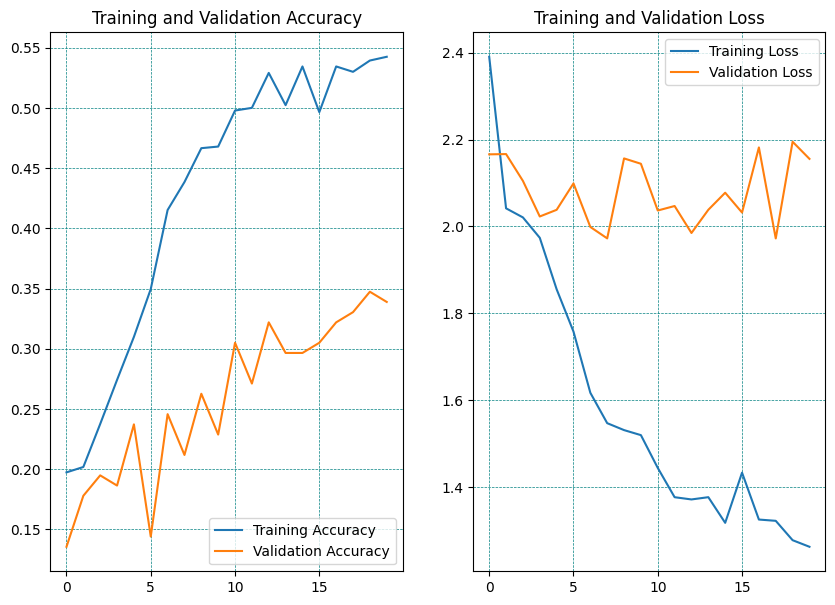

In [82]:
plot_accuracyAndLoss(history, epochs)

### Class Distribution

<BarContainer object of 9 artists>

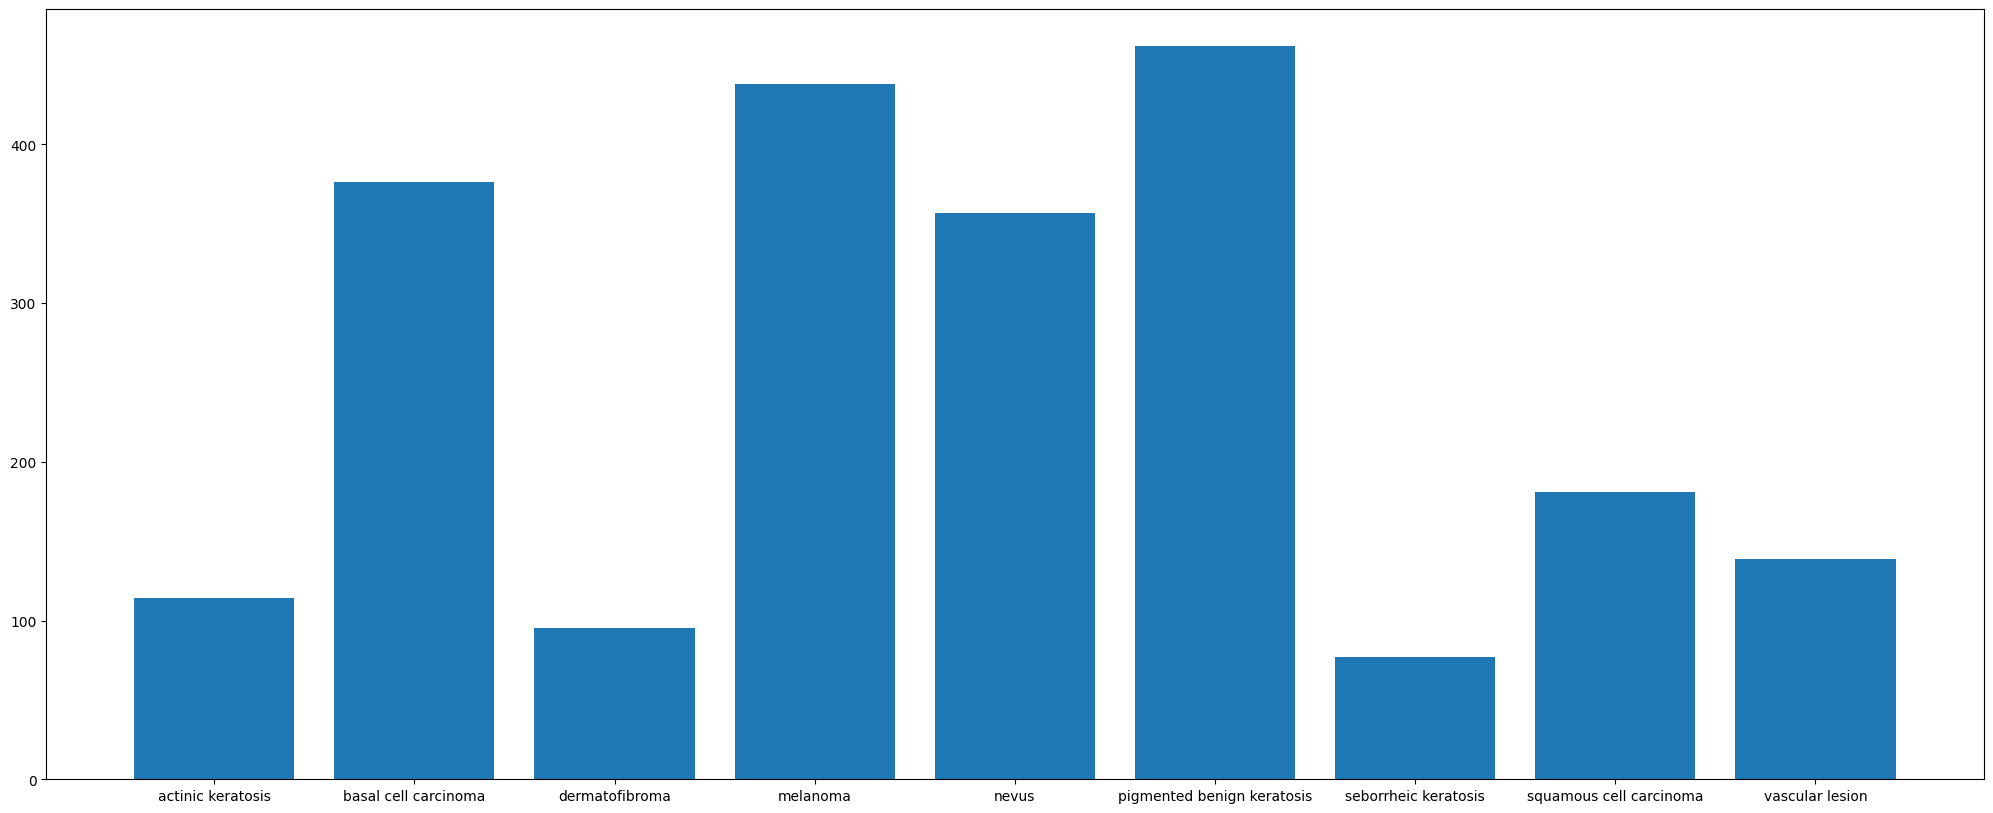

In [29]:
count=[]
for i in class_names:
    count.append(len(list(data_dir_train.glob(i+'/*.jpg'))))
plt.figure(figsize=(25,10))
plt.bar(class_names,count)

### Model Findings

## Model Building & training on the rectified class imbalance data 

To use Augmentor, the following general procedure is followed:


1.   Instantiate a Pipeline object pointing to a directory containing your initial image data set.
2.   Define a number of operations to perform on this data set using your Pipeline object.
3. Execute these operations by calling the Pipeline’s sample() method.



In [30]:
path_to_training_dataset="/content/gdrive/My Drive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"

for i in class_names:
    pipeline = Augmentor.Pipeline(path_to_training_dataset + i)
    pipeline.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    pipeline.sample(500)  #Adding 500 samples per class to make sure that none of the classes are sparse

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/My Drive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FE0E66EDB80>: 100%|██████████| 500/500 [00:31<00:00, 15.72 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/My Drive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FE0E66A7760>: 100%|██████████| 500/500 [00:30<00:00, 16.36 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/My Drive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FE0E6711E50>: 100%|██████████| 500/500 [00:30<00:00, 16.36 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/My Drive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=3072x2304 at 0x7FE0E664EFD0>: 100%|██████████| 500/500 [02:12<00:00,  3.78 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/My Drive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=1504x1129 at 0x7FE0E6600E50>: 100%|██████████| 500/500 [02:15<00:00,  3.70 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/My Drive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FE0E660F460>: 100%|██████████| 500/500 [00:31<00:00, 15.68 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/My Drive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FE0E6607280>: 100%|██████████| 500/500 [01:05<00:00,  7.69 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/My Drive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FE0E665A100>: 100%|██████████| 500/500 [00:30<00:00, 16.26 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/My Drive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FE0E66E1070>: 100%|██████████| 500/500 [00:29<00:00, 16.72 Samples/s]


In [31]:
## Count total number of image generated by Augmentor.
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


Lets see the distribution of augmented data after adding new images to the original training data.

In [32]:
from glob import glob

In [33]:
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['/content/gdrive/My Drive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0025780.jpg_9bef3c22-9d6a-404d-a66d-11cafb3909da.jpg',
 '/content/gdrive/My Drive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0027958.jpg_4de97a88-6f80-491d-abf8-0d3e94fcde3e.jpg',
 '/content/gdrive/My Drive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0029500.jpg_345350b1-6d82-4f04-8023-5386b8a94bfd.jpg',
 '/content/gdrive/My Drive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0026984.jpg_0bdce46e-b1eb-4daa-b70b-2507e6411e33.jpg',
 '/content/gdrive/My Drive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/ac

In [34]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic 

In [35]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [36]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = df2

In [37]:
new_df['Label'].value_counts()

actinic keratosis             500
basal cell carcinoma          500
dermatofibroma                500
melanoma                      500
nevus                         500
pigmented benign keratosis    500
seborrheic keratosis          500
squamous cell carcinoma       500
vascular lesion               500
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### Training the model on the data created using Augmentor

In [38]:
## Creating the Training Dataset

data_dir_train="/content/gdrive/My Drive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train, validation_split=0.2,
                                                               seed = 123, subset='training', image_size=(img_height, img_width),
                                                               batch_size = batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


In [39]:
## Creating the Validation Dataset

val_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train, seed = 123, validation_split=0.2, subset='validation',
                                                             image_size = (img_height, img_width), batch_size = batch_size)


Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


### Creating new model using the Augmented data including Normalization

In [ ]:
model = Sequential()

## First Convulation Layer
model.add(Conv2D(32, kernel_size=(5, 5), activation='relu'))
model.add(Conv2D(32, kernel_size=(5,5), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))

## Second Convulation Layer
model.add(Conv2D(64, kernel_size=(5, 5), activation='relu'))
model.add(Conv2D(64, kernel_size=(5,5), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))

## Third Convolution 
model.add(Conv2D(64, kernel_size=(5,5), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))

# Flatten and put a fully connected Dense layer
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(num_of_classes, activation='softmax'))

model.summary()

### Compiling the Model

In [ ]:
optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

model.compile(loss='categorical_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])

### Training the Model

In [ ]:
epochs = 30
## Your code goes here, use 50 epochs.
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

In [ ]:
plot_accuracyAndLoss(history, epochs)

## Final Observations